In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import time


mockdata = np.load("../data/dataset_all_H1_bootstrap_O3a.npy")



In [3]:
mask = np.where(mockdata[:,6] > 0)
mockdata[:,6][mask] = 1

In [4]:
import networklib as nl
# Example usage
if __name__ == "__main__":
    # Synthetic dataset generation (replace with real data)
    # num_samples = 1000
    features = torch.tensor(mockdata[:, :6])  # First 6 columns for features
    labels = torch.tensor(mockdata[:, 6])     # 7th column for class labels (multiclass)

    # Ensure labels are integers (already assumed to be 0 to 6)
    # labels = labels.astype(torch.int64)  # Convert to int64 for PyTorch compatibility

    # features = torch.rand(num_samples, 6)  # 6 input features
    # labels = torch.randint(0, 2, (num_samples,))  # Binary classification (0 or 1)

    # Split dataset into training and validation sets
    dataset = TensorDataset(features.float(), labels.long())
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False)
    nepochs = 100
    # Initialize and train the model
    # model = nl.GlitchClassifierDynamic(6, 16, 2)
    model = nl.GlitchClassifier(6, 256, 2)
    trained_model, loss_list,train_loss_list,val_loss_list,precision_list,recall_list, accuracy_list  = nl.train_model(model, train_loader, val_loader, epochs=nepochs, lr=0.001, device='cuda')


Epoch 1/100, Train Loss: 0.8088, Val Loss: 0.8143, Precision: 0.2799, Recall: 0.6489, Accuracy: 0.7146
Epoch 2/100, Train Loss: 0.4973, Val Loss: 0.6664, Precision: 0.3633, Recall: 0.0946, Accuracy: 0.8487
Epoch 3/100, Train Loss: 0.4031, Val Loss: 0.4242, Precision: 0.3879, Recall: 0.0843, Accuracy: 0.8519
Epoch 4/100, Train Loss: 0.4414, Val Loss: 0.5377, Precision: 0.3373, Recall: 0.2125, Accuracy: 0.8298
Epoch 5/100, Train Loss: 0.3436, Val Loss: 0.5376, Precision: 0.2870, Recall: 0.5197, Accuracy: 0.7497
Epoch 6/100, Train Loss: 0.3980, Val Loss: 0.3132, Precision: 0.3871, Recall: 0.0562, Accuracy: 0.8541
Epoch 7/100, Train Loss: 0.3207, Val Loss: 0.5027, Precision: 0.4232, Recall: 0.1058, Accuracy: 0.8533
Epoch 8/100, Train Loss: 0.3443, Val Loss: 0.5118, Precision: 0.4190, Recall: 0.3801, Accuracy: 0.8380
Epoch 9/100, Train Loss: 0.3556, Val Loss: 0.3676, Precision: 0.3333, Recall: 0.0019, Accuracy: 0.8585
Epoch 10/100, Train Loss: 0.3075, Val Loss: 0.3385, Precision: 0.4052, Re

In [5]:
total_loss = np.array(loss_list)
train_loss = np.array(train_loss_list)
validation_loss = np.array(val_loss_list)
accuracy = np.array(accuracy_list)
precision = np.array(precision_list)
recall = np.array(recall_list)

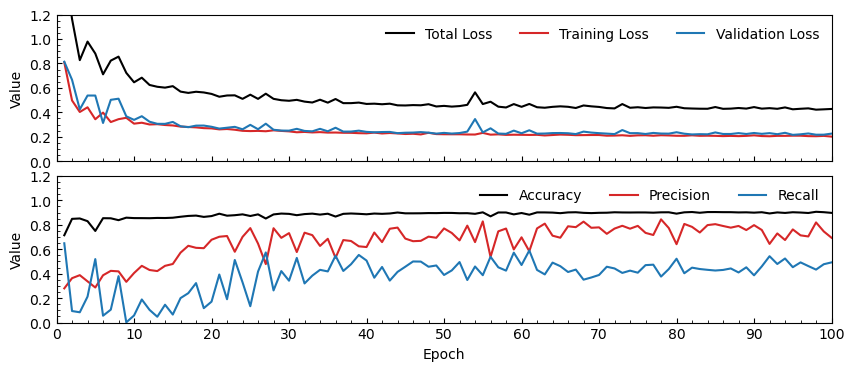

In [6]:

from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)


epochs = np.arange(1, nepochs+1, 1)


fig, ax = plt.subplots(2, 1, squeeze=  False, figsize = (10, 4),sharex=True)
ax[0,0].plot(epochs, total_loss, label = r"Total Loss", zorder= 1, color = "k")
ax[0,0].plot(epochs, train_loss, label = r"Training Loss",zorder = 1, color = "tab:red")
ax[0,0].plot(epochs, validation_loss, label = r"Validation Loss",zorder = 1, color = "tab:blue")
ax[1,0].plot(epochs, accuracy, label = r"Accuracy",zorder = 1, color = "k")
ax[1,0].plot(epochs, precision, label = r"Precision",zorder = 1, color = "tab:red")
ax[1,0].plot(epochs, recall, label = r"Recall",zorder = 1, color = "tab:blue")

# ax[0,0].axhline((total_loss).mean(),zorder= 0,color = "k", linestyle = "dotted")
# ax[0,0].axhline((total_accuracy).mean(),zorder= 0,color = "k", linestyle = "dotted")
ax[0,0].set_ylabel(r"Value")
ax[1,0].set_ylabel(r"Value")
for i in range(2):
    ax[i,0].tick_params(axis="y",direction="in",which="both")
    ax[i,0].tick_params(axis="x",direction="in",which="both")
    ax[i,0].set_yticks(np.arange(0, 1.4, 0.2))
    ax[i,0].set_xticks(np.arange(0, nepochs + 1, nepochs // 10))
    ax[i,0].xaxis.set_minor_locator(MultipleLocator(nepochs//50))
    ax[i,0].yaxis.set_minor_locator(AutoMinorLocator())
ax[1,0].set_xlabel(r"Epoch")
# ax[0,0].set_ylabel("Value")
ax[0,0].set_xlim(0, nepochs)
ax[0,0].set_ylim(0, 1.2)
ax[1,0].set_ylim(0, 1.2)
ax[0,0].legend(frameon=False, ncol=3)
ax[1,0].legend(frameon=False, ncol=3)
fig.subplots_adjust(hspace=0.1)
# ax[0,0].grid(True,which="minor")

In [7]:
device = 'cuda'

tmodel = trained_model.to(device)
tfeatures = features.to(device)


tmodel.eval()
logits = tmodel(tfeatures.float())
probs = torch.softmax(logits, dim=1).cpu().detach().numpy()

In [8]:
mask = np.where(labels == 0)
features_0 = features[mask]
p_0 = probs[:,0][mask]
mask = np.where(labels == 1)
features_1 = features[mask]
p_1 = probs[:,1][mask]



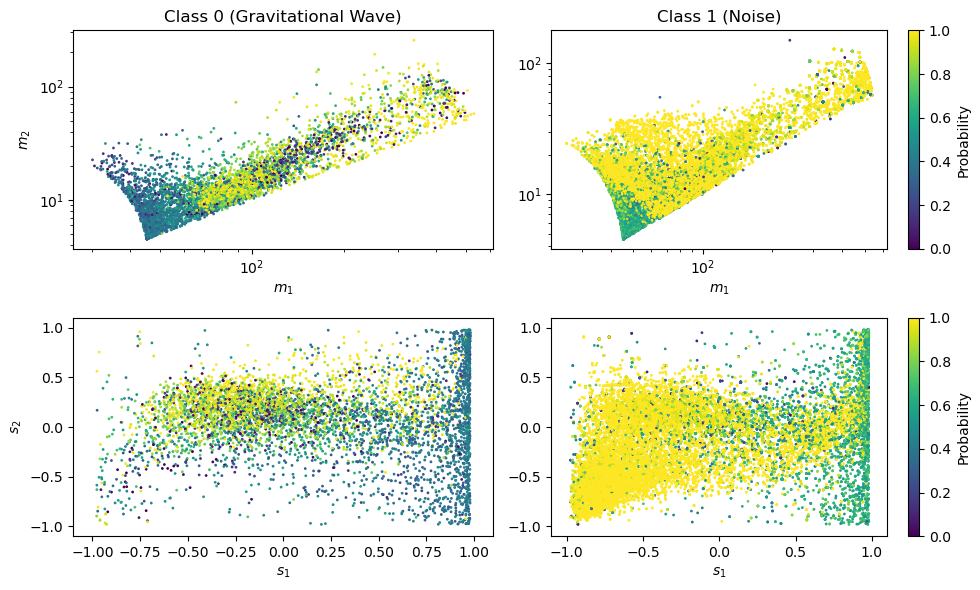

In [9]:
fig, ax = plt.subplots(2, 2, squeeze=False, figsize=(10, 6))

# Scatter plots with individual color maps
scatter_0 = ax[0, 0].scatter(features_0[:,2], features_0[:,3], c=p_0, s=1, cmap='viridis', norm=plt.Normalize(vmin=0, vmax=1))
scatter_1 = ax[0, 1].scatter(features_1[:,2], features_1[:,3], c=p_1, s=1, cmap='viridis', norm=plt.Normalize(vmin=0, vmax=1))

scatter_3 = ax[1, 0].scatter(features_0[:,4], features_0[:,5], c=p_0, s=1, cmap='viridis', norm=plt.Normalize(vmin=0, vmax=1))
scatter_4 = ax[1, 1].scatter(features_1[:,4], features_1[:,5], c=p_1, s=1, cmap='viridis', norm=plt.Normalize(vmin=0, vmax=1))

# Add a colorbar to the entire figure
cbar = fig.colorbar(scatter_0, ax=ax[0,1], shrink=1)
cbar2 = fig.colorbar(scatter_3, ax=ax[1,1], shrink=1)
cbar.set_label("Probability")
cbar2.set_label("Probability")
# Titles, labels, and adjustments
ax[0,0].set_title("Class 0 (Gravitational Wave)")
ax[0,0].set_xlabel("$m_{1}$")
ax[0,0].set_ylabel("$m_{2}$")
ax[0,0].loglog()
ax[0,1].set_title("Class 1 (Noise)")
ax[0,1].set_xlabel("$m_{1}$")
ax[0,1].loglog()


ax[1,0].set_ylabel("$s_{2}$")
ax[1,0].set_xlabel("$s_{1}$")
ax[1,1].set_xlabel("$s_{1}$")

ax[1,0].set_xlim([-1.1,  1.1])
ax[1,1].set_xlim([-1.1,  1.1])
ax[1,0].set_ylim([-1.1,  1.1])
ax[1,1].set_ylim([-1.1,  1.1])
plt.tight_layout()
plt.show()

